# Resnet 练习


In [2]:
import torch
import torch.nn as nn

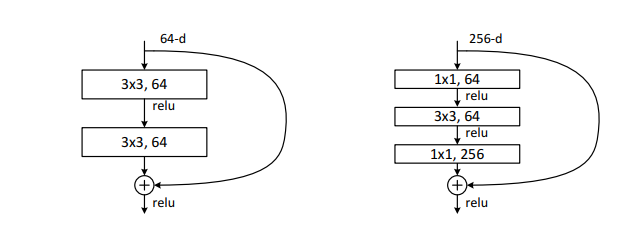


In [3]:
# 单残差块构建
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.convl = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, stride=stride, kernel_size=1, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.convl(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)  # resnet连接
        out = self.relu(out)

        return out

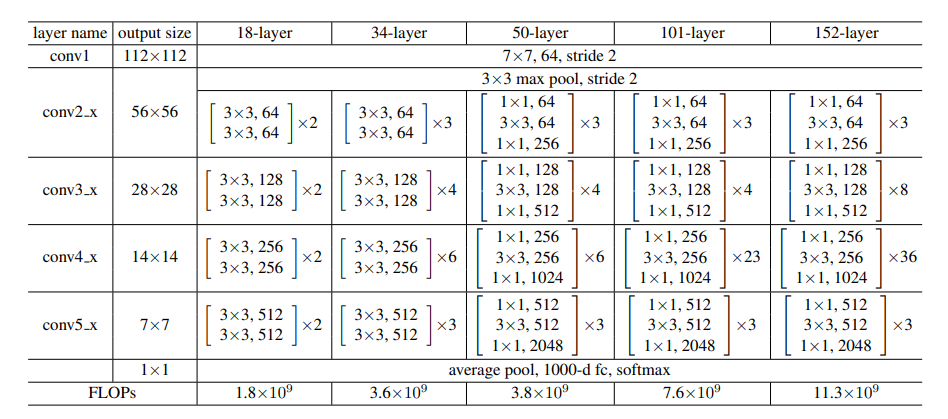


In [4]:
# 整体模型构建
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layer = []
        layer.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layer.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layer)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [5]:
# 实例化
model = ResNet18()
print(model)

# 将模型移动到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from torchsummary import summary  # 测试模型？

summary(model, (1, 224, 224))

ResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (convl): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (convl): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

# 手写数字识别测试


In [6]:
import torch.optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
# 定义数据预处理和数据增强操作
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 将图像转换为张量
        transforms.Normalize((0.5,), (0.5,)),  # 标准化图像
        transforms.RandomHorizontalFlip(p=0.5),  # 以 50% 的概率水平翻转图像
        transforms.RandomRotation(degrees=10),  # 随机旋转图像
    ]
)

In [8]:
# 数据准备
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

In [9]:
# 数据加载
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2
)
test_loader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=1000, num_workers=2
)

In [10]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# 训练模型
los = []
epo = []

epoch_num = 3

for epoch in range(epoch_num):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 移到GPU计算

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epoch_num}], Loss: {running_loss/len(train_loader):.4f}")

    los.append(running_loss / len(train_loader))
    epo.append(epoch)

Epoch [1/3], Loss: 0.2891
Epoch [2/3], Loss: 0.1254
Epoch [3/3], Loss: 0.0972


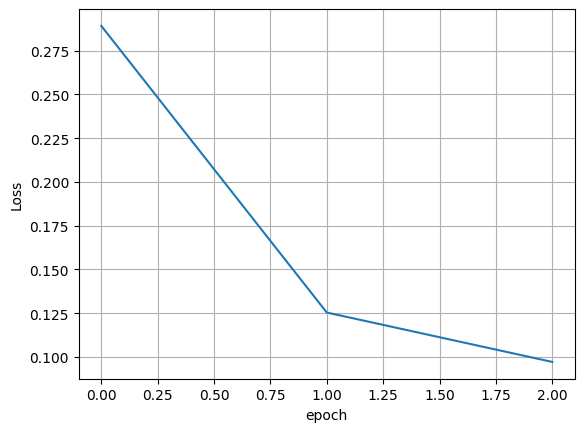

In [12]:
# 数据可视化
import matplotlib.pyplot as plt

plt.plot(epo, los)
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid(True)  # 显示网格
plt.show()

In [13]:
# 测试模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Accuracy of the model on the test images: 97.52%


In [14]:
torch.save(model.state_dict(), "ResNetmodel.pth")